In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Expansion to Vector Es and Rs, Symmetric Weights

In [2]:
def step(x, e, r, U):
    e = x - U(r)
    r = r + F.linear(e, U.weight.T, None)
    return e, r

In [4]:
sizes = [4, 3]
# Parameter Initialisation1
U = nn.Linear(sizes[1], sizes[0], bias=False) # Tricky shape (back to front) (R, E)

# Initialise Dataset
x = torch.randint(1, 4, (sizes[0],)).float()
e = torch.zeros((sizes[0],))
r = torch.zeros((sizes[1],))
i = 0

print("Initial state:")
print(f"x: {x}")
print(f"e: {e}")
print(f"r: {r}")

Initial state:
x: tensor([2., 2., 1., 3.])
e: tensor([0., 0., 0., 0.])
r: tensor([0., 0., 0.])


In [14]:
# Manual Iteration with no learning
i += 1
with torch.no_grad():
    e, r = step(x, e, r, U)

print(f"state after {i} steps:")
print(f"x: {x}")
print(f"pred: {U(r).data}")
print(f"e: {e}  - MeanAbs: {e.abs().mean():.4f}")
print(f"r: {r.data}")

state after 10 steps:
x: tensor([2., 2., 1., 3.])
pred: tensor([ 1.5618,  1.2544, -0.9561,  2.4613])
e: tensor([0.4834, 0.7294, 1.9931, 0.5528])  - MeanAbs: 0.9397
r: tensor([ 5.2332, -1.5300, -0.0620])


Learning with symmetric weights

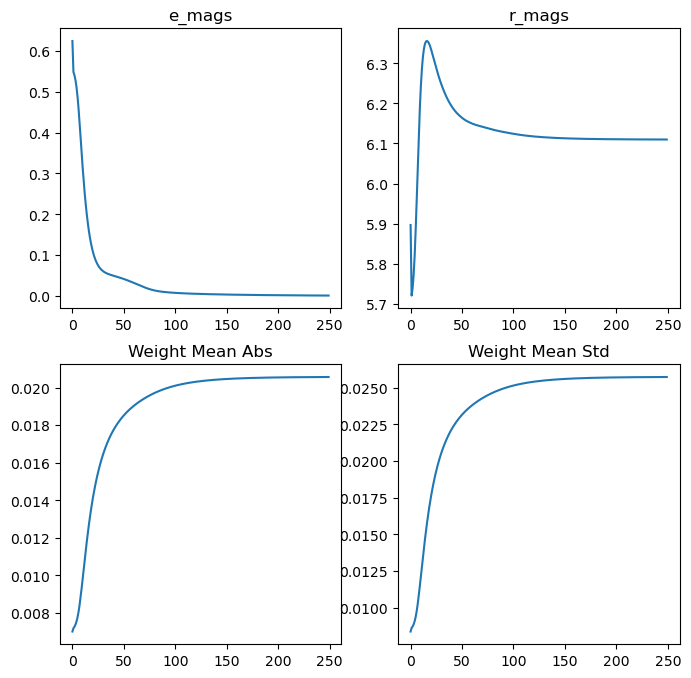

In [15]:
# Parameter Initialisation
sizes = [784, 64]
steps = 5
U = nn.Linear(sizes[1], sizes[0], bias=False)
U.weight.data *= 0.1
sym_e_mags = []
sym_r_mags = []
sym_U_mags = []
sym_U_stds = []

# Build dataset
batch_size = 32
X = torch.randint(1, 4, (batch_size, sizes[0],)).float()

# Hyperparameters
lr = 0.000034
epochs = 250
reg_coeff = 0.0

# Learning Loop
for ep in range(epochs):
    epoch_e_mags = torch.zeros(batch_size)
    epoch_r_mags = torch.zeros(batch_size)
    epoch_U_mags = torch.zeros(batch_size)
    epoch_U_stds = torch.zeros(batch_size)

    for b in range(batch_size):
        x = X[b]

        e = torch.zeros((sizes[0],))
        r = torch.zeros((sizes[1],))


        for step_i in range(steps):
            with torch.no_grad():
                e, r = step(x, e, r, U)

            if step_i > 0:
                with torch.no_grad():
                    U.weight.grad = -(e.unsqueeze(1) * r.unsqueeze(0)) # -ve because we are performing grad descent, yet we want to increase connectivity 
            
                # L2 Regularisation
                reg = reg_coeff * U.weight.square().mean()
                reg.backward()
                
                # Parameter Update
                U.weight.data -= lr * U.weight.grad

        # Stat tracking
        epoch_e_mags[b] = e.abs().mean().item()
        epoch_r_mags[b] = r.abs().mean().item()
        epoch_U_mags[b] = U.weight.data.abs().mean().item()
        epoch_U_stds[b] = U.weight.data.std().item()

    # Stat tracking
    sym_e_mags.append(epoch_e_mags.mean().item())
    sym_r_mags.append(epoch_r_mags.mean().item())
    sym_U_mags.append(epoch_U_mags.mean().item())
    sym_U_stds.append(epoch_U_stds.mean().item())

# Plot
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs[0,0].plot(sym_e_mags)
axs[0,0].set_title('e_mags')
axs[0,1].plot(sym_r_mags)
axs[0,1].set_title('r_mags')
axs[1,0].plot(sym_U_mags, label="Mean Abs")
axs[1,0].set_title('Weight Mean Abs')
axs[1,1].plot(sym_U_stds, label="Mean Stds")
axs[1,1].set_title('Weight Mean Std')
plt.show()


In [16]:
# error should be bigger for untrained x
dataset_e_mags = torch.zeros(len(X))
for i, x in enumerate(X):
    e = torch.zeros((sizes[0],))
    r = torch.zeros((sizes[1],))
    for _ in range(5):
        e = e.detach()
        r = r.detach()
        e, r = step(x, e, r, U)
    dataset_e_mags[i] = e.abs().mean().item()
print(f"Dataset e_mag: {dataset_e_mags.mean().item():.4f}")

x = torch.randint(1, 4, (sizes[0],)).float()
for _ in range(5):
    e = e.detach()
    r = r.detach()
    e, r = step(x, e, r, U)
print(f"Untrained e_mag: {e.abs().mean().item():.4f}")

Dataset e_mag: 0.0034
Untrained e_mag: 0.6530


In [17]:
# New Update rule with assymetric weights
def step2(x, e, r, U, V):
    e = x - U(r)
    r = r + V(e)
    return e, r

In [39]:
sizes = [4,4]
# Parameter Initialisation
U = nn.Linear(sizes[1],sizes[0], bias=False)
V = nn.Linear(sizes[0],sizes[1], bias=False)

# Data Initialisation
x = torch.randint(1, 4, (sizes[0],)).float()
e = torch.zeros((sizes[0],))
r = torch.zeros((sizes[1],))
i = 0

print("Initial state:")
print(f"x: {x}")
print(f"e: {e}")
print(f"r: {r}")

Initial state:
x: tensor([2., 2., 1., 2.])
e: tensor([0., 0., 0., 0.])
r: tensor([0., 0., 0., 0.])


In [40]:
# Manual Iteration with no learning
i += 1
with torch.no_grad():
    e, r = step2(x, e, r, U, V)

print(f"state after {i} steps:")
print(f"x: {x}")
print(f"pred: {U(r).data}")
print(f"e: {e}  - MeanAbs: {e.abs().mean():.4f}")
print(f"r: {r.data}")

state after 1 steps:
x: tensor([2., 2., 1., 2.])
pred: tensor([ 0.3297, -0.8145,  0.4358, -0.3784])
e: tensor([2., 2., 1., 2.])  - MeanAbs: 1.7500
r: tensor([-1.5861, -0.5786,  0.8783, -0.6919])


Learning with Assymetric weights

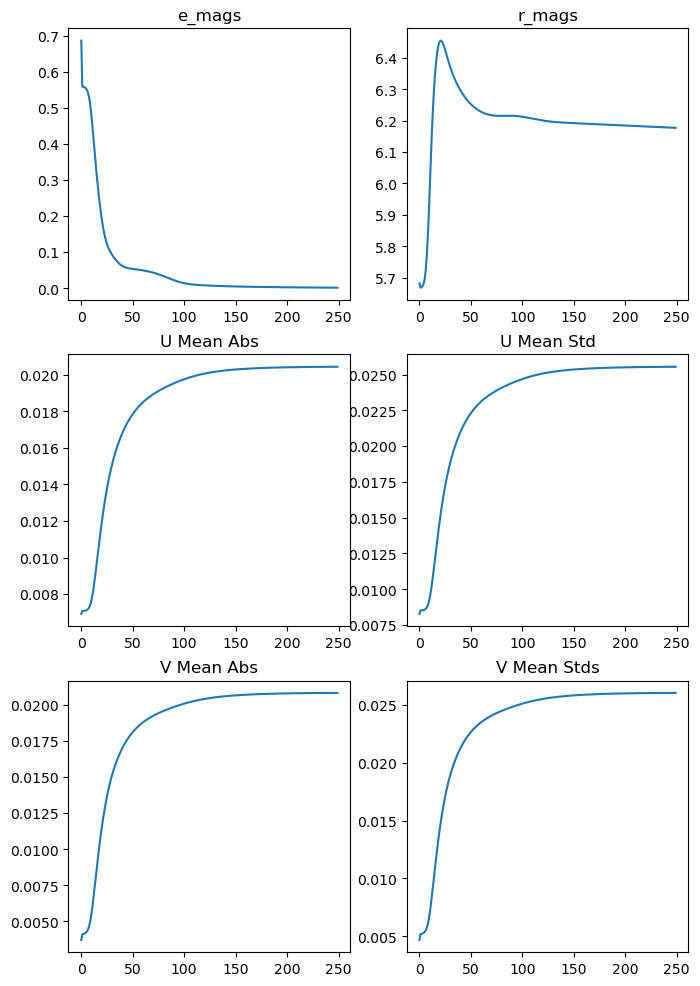

In [41]:
# Parameter Initialisation
sizes = [784, 64]
steps = 5
U = nn.Linear(sizes[1], sizes[0], bias=False)
V = nn.Linear(sizes[0], sizes[1], bias=False)
U.weight.data *= 0.1
V.weight.data *= 0.1
asym_e_mags = []
asym_r_mags = []
asym_U_mags = []
asym_U_stds = []
asym_V_mags = []
asym_V_stds = []

# Build dataset
batch_size = 32
X = torch.randint(1, 4, (batch_size, sizes[0],)).float()

# Hyperparameters
lr = 0.000034
epochs = 250
reg_coeff = 0.0

# Training Loop
for ep in range(epochs):
    epoch_e_mags = torch.zeros(batch_size)
    epoch_r_mags = torch.zeros(batch_size)
    epoch_U_mags = torch.zeros(batch_size)
    epoch_U_stds = torch.zeros(batch_size)
    epoch_V_mags = torch.zeros(batch_size)
    epoch_V_stds = torch.zeros(batch_size)

    for b in range(batch_size):
        x = X[b]

        e = torch.zeros((sizes[0],))
        r = torch.zeros((sizes[1],))


        for step_i in range(steps):
            with torch.no_grad(): 
                e, r = step2(x, e, r, U, V)

            if step_i > 0:
                with torch.no_grad():
                    U.weight.grad = -(e.unsqueeze(1) @ r.unsqueeze(0)) # Ideally this is performed halfway through step2()
                    V.weight.grad = -(r.unsqueeze(1) @ e.unsqueeze(0))

                reg = reg_coeff * (U.weight.square().mean() + V.weight.square().mean())
                reg.backward()

                U.weight.data -= lr * U.weight.grad
                V.weight.data -= lr * V.weight.grad
                
        # Stat tracking
        epoch_e_mags[b] = e.abs().mean().item()
        epoch_r_mags[b] = r.abs().mean().item()
        epoch_U_mags[b] = U.weight.data.abs().mean().item()
        epoch_U_stds[b] = U.weight.data.std().item()
        epoch_V_mags[b] = V.weight.data.abs().mean().item()
        epoch_V_stds[b] = V.weight.data.std().item()
    
    # Stat tracking
    asym_e_mags.append(epoch_e_mags.mean().item())
    asym_r_mags.append(epoch_r_mags.mean().item())
    asym_U_mags.append(epoch_U_mags.mean().item())
    asym_U_stds.append(epoch_U_stds.mean().item())
    asym_V_mags.append(epoch_V_mags.mean().item())
    asym_V_stds.append(epoch_V_stds.mean().item())

fig, axs = plt.subplots(3, 2, figsize=(8,12))
axs[0,0].plot(asym_e_mags)
axs[0,0].set_title('e_mags')
axs[0,1].plot(asym_r_mags)
axs[0,1].set_title('r_mags')
axs[1,0].plot(asym_U_mags, label="U Mean Abs")
axs[1,0].set_title('U Mean Abs')
axs[1,1].plot(asym_U_stds, label="U Mean Stds")
axs[1,1].set_title('U Mean Std')
axs[2,0].plot(asym_V_mags, label="V Mean Abs")
axs[2,0].set_title('V Mean Abs')
axs[2,1].plot(asym_V_stds, label="V Mean Stds")
axs[2,1].set_title('V Mean Stds')
plt.show()

In [42]:
# error is bigger for untrained x
dataset_e_mags = torch.zeros(len(X))
for i, x in enumerate(X):
    e = torch.zeros((sizes[0],))
    r = torch.zeros((sizes[1],))
    for _ in range(5):
        with torch.no_grad():
            e, r = step2(x, e, r, U, V)
    dataset_e_mags[i] = e.abs().mean().item()
print(f"Dataset e_mag: {dataset_e_mags.mean().item():.4f}")

x = torch.randint(1, 4, (sizes[0],)).float()
for _ in range(4):
    e = e.detach()
    r = r.detach()
    e, r = step2(x, e, r, U, V)
print(f"Untrained x: {x.shape} - e.mag: {e.abs().mean().item():.4f}")

Dataset e_mag: 0.0048
Untrained x: torch.Size([784]) - e.mag: 0.7057


Symmetric VS Asymmetric

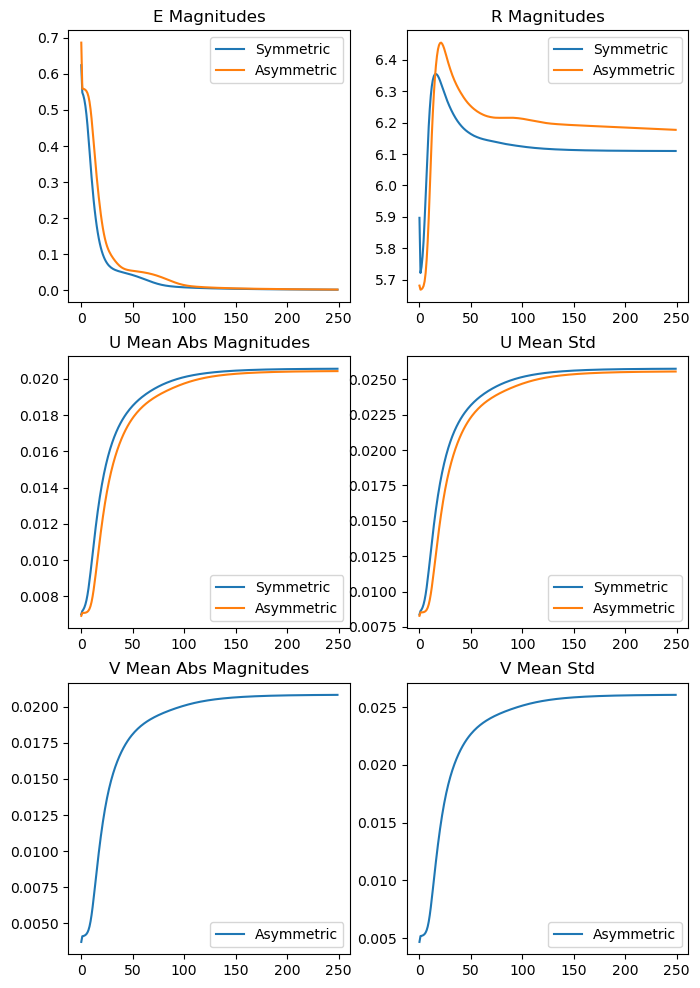

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(8,12))
axs[0,0].plot(sym_e_mags, label="Symmetric")
axs[0,0].plot(asym_e_mags, label="Asymmetric")
axs[0,0].legend()
axs[0,0].set_title('E Magnitudes')
axs[0,1].plot(sym_r_mags, label="Symmetric")
axs[0,1].plot(asym_r_mags, label="Asymmetric")
axs[0,1].legend()
axs[0,1].set_title('R Magnitudes')
axs[1,0].plot(sym_U_mags, label="Symmetric")
axs[1,0].plot(asym_U_mags, label="Asymmetric")
axs[1,0].legend()
axs[1,0].set_title('U Mean Abs Magnitudes')
axs[1,1].plot(sym_U_stds, label="Symmetric")
axs[1,1].plot(asym_U_stds, label="Asymmetric")
axs[1,1].legend()
axs[1,1].set_title('U Mean Std')
axs[2,0].plot(asym_V_mags, label="Asymmetric")
axs[2,0].legend()
axs[2,0].set_title('V Mean Abs Magnitudes')
axs[2,1].plot(asym_V_stds, label="Asymmetric")
axs[2,1].legend()
axs[2,1].set_title('V Mean Std')
plt.show()
